In [1]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter
from numba import njit
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from scipy.spatial import KDTree
# from numba_kdtree import KDTree

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

# import vortrace as vt
import Cvortrace
from vortrace.vortrace import ProjectionCloud

In [2]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27
textheight = 657.3189 / 72.27

mpl.rcParams.update({'font.size': 8})

In [3]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

# merger plot

In [10]:
# sim0 = ('142', '116', '04')
# sim1 = ('129', '116', '04')

sim0 = ('129', '142', '04') # aa
sim1 = ('129', '116', '04') # a
# sim1 = ('142', '129', '06') # e

In [11]:
def load_galaxy(sim, idx=320):
    Rs, Vv, ecc = sim
    key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
    return galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              idx, orient=True)

In [12]:
import importlib
importlib.reload(galaxy)

<module 'galaxy' from '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/note/galaxy.py'>

In [13]:
# idx_list = np.array([40, 80, 90, 100, 200, 320])
idx_list = np.array([60, 70, 80, 90, 100, 110, 120, 200, 320])
t_list = 0.025 * idx_list
print(t_list)

gal_idx = {}
for idx in tqdm(idx_list):
    gal_idx[idx] = load_galaxy(sim0, idx=idx)

[1.5  1.75 2.   2.25 2.5  2.75 3.   5.   8.  ]


100%|██████████| 9/9 [00:23<00:00,  2.62s/it]


In [14]:
# orient wrt last idx
gal_last = gal_idx[idx_list[-1]]
gal_last.do_orient()
k, theta = gal_last.CenterOfMass.k, gal_last.CenterOfMass.theta

for idx in tqdm(idx_list[:-1]):
    gal = gal_idx[idx]
    COM, COMV, _, _ = gal._get_COM_COMV()
    gal._orient(COM, COMV, k, theta)

100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


In [15]:
print(theta*180/np.pi)

129.90346290333002


In [16]:
gal_idx[idx_list[0]].CenterOfMass.AngularMomentum

array([ 3.5976404 , -2.88303344, 12.03914799])

In [17]:
gal_last.CenterOfMass.AngularMomentum

array([ -1.55158871, -59.1807776 , -49.50589417])

In [18]:
dx = 0.1
np.arange(0, 1, dx) + dx/2

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [20]:
L = 1
Nres = 4
dL = L/Nres
xpts = np.arange(-L/2, L/2, dL) + dL/2.
ypts = np.arange(-L/2, L/2, dL) + dL/2.

for i,xg in enumerate(xpts):
    for j,yg in enumerate(ypts):
        print(xg, yg)

-0.375 -0.375
-0.375 -0.125
-0.375 0.125
-0.375 0.375
-0.125 -0.375
-0.125 -0.125
-0.125 0.125
-0.125 0.375
0.125 -0.375
0.125 -0.125
0.125 0.125
0.125 0.375
0.375 -0.375
0.375 -0.125
0.375 0.125
0.375 0.375


In [21]:
a = np.random.rand(100, 3)
tree = KDTree(a)
h, _ = tree.query(a, 9)

In [22]:
np.zeros((len(xpts), len(ypts)))

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [23]:
h[:,-1]

array([0.26984053, 0.27974891, 0.26862415, 0.40122554, 0.2288318 ,
       0.26675327, 0.30408646, 0.28039525, 0.29952234, 0.3424249 ,
       0.24495673, 0.34616025, 0.38330814, 0.30136594, 0.24832223,
       0.22328185, 0.38187571, 0.26995919, 0.25941183, 0.27750744,
       0.25731149, 0.29572314, 0.25326594, 0.2425981 , 0.51959841,
       0.26052521, 0.23942866, 0.28356616, 0.34296382, 0.38539743,
       0.36694109, 0.33024267, 0.26756442, 0.3989774 , 0.28147465,
       0.38069327, 0.24371769, 0.24876051, 0.24787373, 0.22653768,
       0.2425981 , 0.29474833, 0.35274469, 0.25599265, 0.26634037,
       0.26634037, 0.30122073, 0.28493117, 0.30442519, 0.2227838 ,
       0.28191561, 0.26048237, 0.27458286, 0.28493117, 0.26948298,
       0.30245683, 0.25536077, 0.26275616, 0.24193471, 0.30997499,
       0.33985824, 0.32634892, 0.25607622, 0.31163675, 0.36419709,
       0.32074844, 0.30450243, 0.34823889, 0.27046631, 0.27344637,
       0.24908203, 0.19727672, 0.2744487 , 0.29203069, 0.36614

In [24]:
def gadget_spline(u, h=1, M=1):
    pre = M * 8 / (np.pi * h**3)
    ans = np.zeros_like(u)
    ans0 = 1 - 6*u**2 + 6 * u**3
    ans1 = 2 * (1-u)**3
    
    key0 = u <= 0.5
    key1 = np.logical_and(u > 0.5, u <= 1)
    ans[key0] = ans0[key0]
    ans[key1] = ans1[key1]
    
    ans *= pre
    
    return ans

def get_sigma_interp():
    blist = np.linspace(0, 1, 1000)
    slist = np.linspace(-1, 1, 1000)
    bgrid, sgrid = np.meshgrid(blist, slist, indexing='ij')
    
    rgrid = np.sqrt(bgrid**2 + sgrid**2)
    Wgrid = gadget_spline(rgrid, 1)
    
    sigma = np.trapz(Wgrid, slist, axis=1)
    return blist, sigma

# @njit
def sum_kernel_surface_dens(xpts, ypts, x, y, M, h, bint, sigmaint):
    
    pos = np.transpose([x, y])
    sigma = np.zeros(len(xpts)*len(ypts))
    
    xgrid, ygrid = np.meshgrid(xpts, ypts, indexing='ij')
    grid = np.transpose([xgrid.ravel(), ygrid.ravel()])
    
    tree_grid = KDTree(grid)

    # now do a ball query
    ball_idx = tree_grid.query_ball_point(pos, h)
    
    ball_idx_filter = [b for b in ball_idx if b]
    
    part_idx = np.concatenate([[i] * len(b) for i,b in enumerate(ball_idx) if b])
    ball_idx = np.concatenate(ball_idx_filter)
    
    # now get impact parameter
    b = np.linalg.norm(pos[part_idx] - grid[ball_idx], axis=1)
    sigma_ = M[part_idx]/h[part_idx]**3 * np.interp(b/h[part_idx], bint, sigmaint)
    sigma = np.bincount(ball_idx, weights=sigma_, minlength=len(xpts)*len(ypts))

    sigma = np.reshape(sigma, (len(xpts), len(ypts)))

    return sigma
    

def plot_star_panel(fig, ax, gal, ix, iy, cmap=None):
    L = 30
    Nres = 128
    # vmin = 1e-4
    # vmax = 1e-1
    vmin = 1e-5
    vmax = 1
    sigma = 0.5

    sn, sub = gal.sn, gal.sub
    is_star = sn.part4.GFM_StellarFormationTime > 0
    pos = sn.part4.rotpos[is_star]
    mass = sn.part4.mass.value[is_star]
    
    # get softening lengths as dist to 8th nearest neighbor
    tree = KDTree(pos)
    h, _ = tree.query(pos, 33)
    h = h[:,-1]
    
    dL = L/Nres
    xpts = np.arange(-L/2, L/2, dL) + dL/2.
    ypts = np.arange(-L/2, L/2, dL) + dL/2.
    
    x = pos[:,ix]
    y = pos[:,iy]

    bint, sigmaint = get_sigma_interp()
    H = sum_kernel_surface_dens(xpts, ypts, x, y, mass, h, bint, sigmaint)
    
    # H, _, _, _ = binned_statistic_2d(x, y, mass/dx/dy, statistic='sum', bins=[xbins, ybins])
    # H = gaussian_filter(H, sigma=sigma)
    
    if vmin is not None:
        H = np.clip(H, vmin, vmax)
    
    extent = [-L/2, L/2, -L/2, L/2]
    im = ax.imshow(H.T, origin='lower', extent=extent, 
                       norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)
    
    return im

(1e-05, 1.0)
CPU times: user 4.96 s, sys: 303 ms, total: 5.26 s
Wall time: 5.36 s


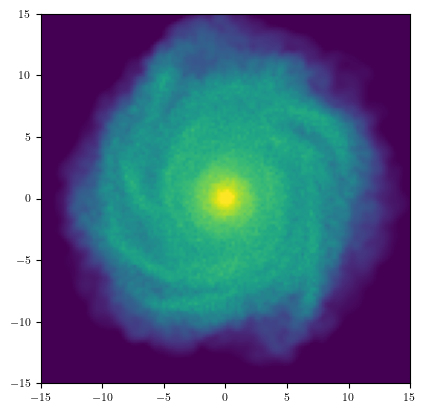

In [25]:
%%time
fig, ax = plt.subplots(1, 1)
gal = gal_idx[320]

im = plot_star_panel(fig, ax, gal, 0, 1)
print(im.get_clim())

In [26]:
im.get_clim()

(1e-05, 1.0)

In [28]:
def mesh_integrate(pos, rho, L, Nres):
    # reshift box
    pos = np.copy(pos)
    rho = np.copy(rho)
    pos += 3*L
    boundbox = [0, 6*L, 0, 6*L, 0, 6*L]
    in_box = np.full(len(pos), True)
    for i in range(3):
        in_box_i = np.logical_and(pos[:,i] > boundbox[2*i], pos[:,i] < boundbox[2*i+1])
        in_box = np.logical_and(in_box, in_box_i)
    
    pos = pos[in_box]
    rho = rho[in_box]
    # for i in range(3):
        # print(np.max(pos[:,i]), np.min(pos[:,i]), L*3)
    
    # print(len(pos))
    # print(rho[:10])
    
    # print(rho[:10])
    pc = ProjectionCloud(pos, rho, boundbox=boundbox)
    pc._cloud.buildTree()
    # print(dir(pc._cloud))
    # print(pc.boundbox)
    
    dx = L/Nres
    
    grid_points = np.linspace(-L/2+dx/2., L/2-dx/2., Nres)
    edge_points = np.array([-L/2., L/2.])
    
    # x-y projection
    xv, yv, zv = np.meshgrid(grid_points, grid_points, edge_points)
    xv = xv.flatten()
    yv = yv.flatten()
    zv = zv.flatten()
    pts = np.array([xv, yv, zv], order='F')
    pts = np.transpose(pts)
    pts_start = pts[::2] + 3*L
    pts_end = pts[1::2] + 3*L
    
    # print(pts_start)
    # print(pts_end)
    
    proj = Cvortrace.Projection(pts_start, pts_end)
    proj.makeProjection(pc._cloud)
    sigma_xy = proj.returnProjection()
    # sigma_xy /= dx**2
    # print(sigma_xy[:10])
    sigma_xy = np.reshape(sigma_xy, (Nres, Nres))
    
    # x-z projection
    xv, yv, zv = np.meshgrid(grid_points, edge_points, grid_points)
    xv = xv.flatten()
    yv = yv.flatten()
    zv = zv.flatten()
    pts = np.array([xv, yv, zv], order='F')
    pts = np.transpose(pts)
    # print(pts)
    pts_start = pts[:Nres**2] + 3*L
    pts_end = pts[Nres**2:] + 3*L
    
    # print(pts_start)
    # print(pts_end)
    
    proj = Cvortrace.Projection(pts_start, pts_end)
    proj.makeProjection(pc._cloud)
    sigma_xz = proj.returnProjection()
    # sigma_xz /= dx**2
    sigma_xz = np.reshape(sigma_xz, (Nres, Nres))
    
    return sigma_xy, sigma_xz

In [29]:
sigma_xy = {}
sigma_xz = {}

Nres = 256
L = 30

for idx in tqdm(gal_idx.keys()):
    gal = gal_idx[idx]
    sn, sub = gal.sn, gal.sub
    pos = sn.part0.rotpos
    rho = sn.part0.rho.value
    
    sigma_xy[idx], sigma_xz[idx] = mesh_integrate(pos, rho, L, Nres)

100%|██████████| 9/9 [00:59<00:00,  6.61s/it]


In [30]:
def plot_gas_panel(fig, ax0, ax1, sigma_xy, sigma_xz):
    L = 30
    vmin = 1e-4
    vmax = 1e-1
    
    extent = [-L/2., L/2., -L/2., L/2.]
    im0 = ax0.imshow(sigma_xz.T, origin='lower', extent=extent, 
                       norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
                       cmap='Blues')
    
    im1 = ax1.imshow(sigma_xy.T, origin='lower', extent=extent, 
                       norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
                       cmap='Blues')
    
    return im0, im1

100%|██████████| 9/9 [00:43<00:00,  4.84s/it]


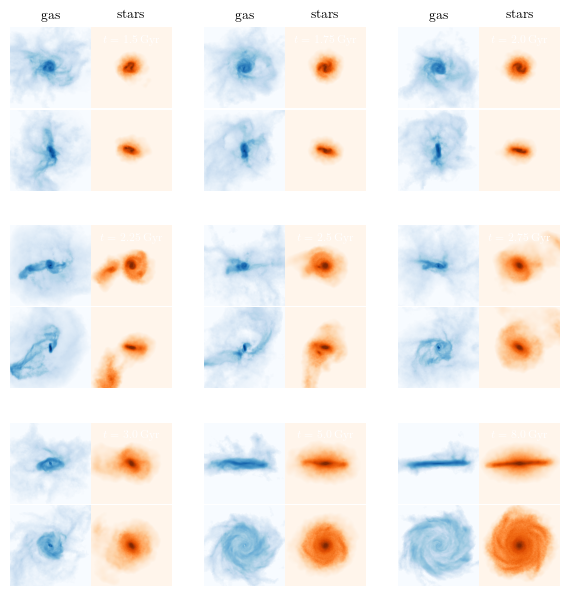

In [31]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(textwidth, 0.8*textheight))
outer = gridspec.GridSpec(3, 3)

idx_list = list(gal_idx.keys())

for i in tqdm(range(9)):
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outer[i], wspace=0, hspace=0)
    idx = idx_list[i]
    gal = gal_idx[idx]
    
    ax0 = plt.Subplot(fig, inner[0])
    ax1 = plt.Subplot(fig, inner[2])
    
    im0, im1 = plot_gas_panel(fig, ax0, ax1, sigma_xy[idx], sigma_xz[idx])
        
    ax0.set(xticks=[], yticks=[])
    ax1.set(xticks=[], yticks=[])
    
    if i < 3:
        ax0.set_title(r'$\textrm{gas}$')
    
    ax0.axis('off')
    ax1.axis('off')
    
    fig.add_subplot(ax0)
    fig.add_subplot(ax1)
        
    ax0 = plt.Subplot(fig, inner[1])
    ax1 = plt.Subplot(fig, inner[3])
        
    im0 = plot_star_panel(fig, ax0, gal, 0, 2, cmap='Oranges')
    im1 = plot_star_panel(fig, ax1, gal, 0, 1, cmap='Oranges')
    
    ax0.set(xticks=[], yticks=[])
    ax1.set(xticks=[], yticks=[])
    
    tstr = str(round(gal.sn.Time.value, 2))
    ax0.text(0, 9, r'$t='+tstr+r'\,\textrm{Gyr}$', c='w', fontsize=8, ha='center')
    
    if i < 3:
        ax0.set_title(r'$\textrm{stars}$')
    
    ax0.axis('off')
    ax1.axis('off')
    
    fig.add_subplot(ax0)
    fig.add_subplot(ax1)

# for ax in fig.axes:
#     box = ax.get_position()
#     ax.set_position([box.x0, box.y0, box.width, box.height])

# fig.tight_layout()
fig.savefig('surfdens.pdf')